# The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Part 1: Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

class Calibration(): 
    
    '''Computes the camera calibration matrix (mtx) and distortion coefficients (dist) using a set of chessboard images. 
    Also applies distortion correction to raw images.'''
    
    def __init__(self): 
        
        self.mtx, self.dist = self.get_mtx_dist()
        
    def get_mtx_dist(self): 
        
        #list the calibration images 
        images = glob.glob(os.path.join('camera_cal', 'calibration*.jpg'))
        
        #arrays to hold the points
        object_points = []
        image_points = []
        
        #create object points
        objp = np.zeros((6*9, 3), np.float32)
        objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
        
        #iterate through the images and find the chessboard corners
        for image in images: 
            img = cv2.imread(image)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            #find chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            
            #if we find corners, add points to object and image points
            if ret == True: 
                image_points.append(corners)
                object_points.append(objp)
                
        #get the image size
        img_size = (gray.shape[1], gray.shape[0])
        
        #calibrates given image points, object points, and shape of the grayscale image
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_size, None, None)
        
        return mtx, dist
    
    def undistort(self, image): 
        
        undist = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
        return undist
            

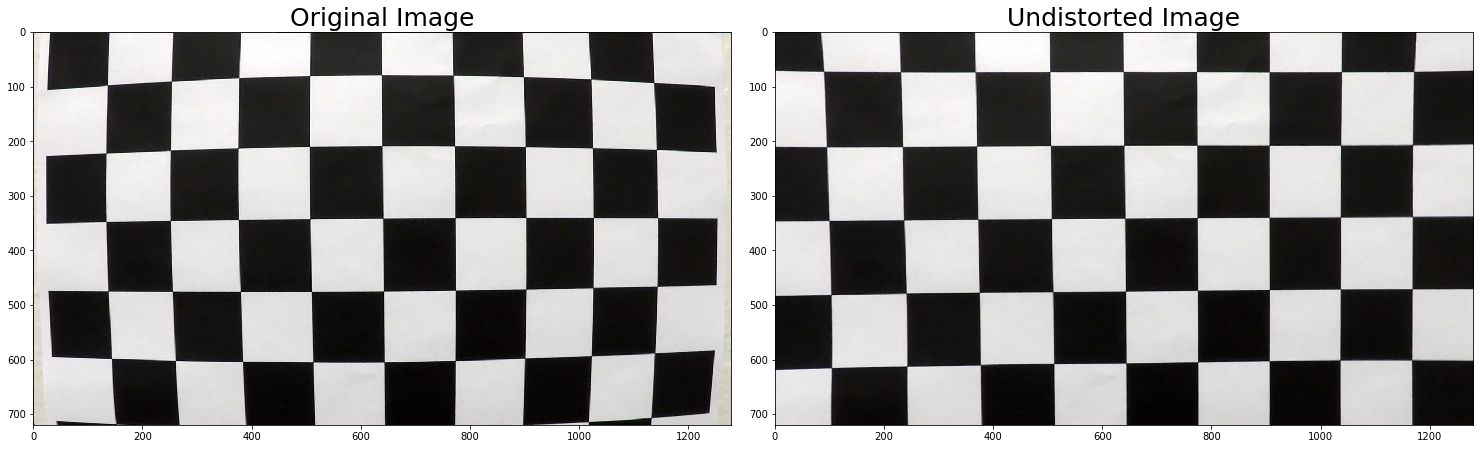

In [25]:
#utilize the calibration class to display the original calibration image and the undistorted image
image = mpimg.imread('camera_cal/calibration1.jpg')
camera_calibration = Calibration()
undistorted_image = camera_calibration.undistort(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistorted_image')

### Part 2: Binary Thresholded Image

In [3]:

class Binary_Threshold():
    
    '''Uses an HLS color transform and and Sobel gradients to create a thresholded binary image.
    Also adds a region of interest mask to the image around where the road lane lines are.'''
    
    def abs_sobel_threshold(self, image, orient='x', sobel_kernel = 3, thresh = (0, 255)):
        
        #convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        #take derivative in x and absolute value of the derivative 
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        elif orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
            
        #scale to 8-bit
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        
        return binary_output
              
    def hls_threshold(self, image, s_thresh = (0, 255)): 
        
        #convert to hls and isolate color channels
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        H = hls[:, :, 0]
        L = hls[:, :, 1]
        S = hls[:, :, 2]
        
        #threshold the S channel
        binary = np.zeros_like(S)
        binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
        
        return binary
                 
    def combined_binary_image(self, image):
        
        #hls threshold
        hls_binary = self.hls_threshold(image, s_thresh = (120, 255))
        
        #sobel threshold
        gradx = self.abs_sobel_threshold(image, orient = 'x', thresh = (20, 255))
        grady = self.abs_sobel_threshold(image, orient = 'y', thresh = (25, 255))
        
        #combine threshold
        combined_binary_image = np.zeros_like(hls_binary)
        combined_binary_image[((gradx == 1) & (grady == 1)) | (hls_binary ==1)] = 1
        
        #apply region of interest mask
        binary = self.region_of_interest(combined_binary_image)
        return binary 
            
    def region_of_interest(self, image): 
        #applies a region of interest mask
        
        image_size = image.shape[:2]
        
        vertices = np.array([[(image_size[1] / 2 -70, image_size[0] / 2 + 80 ),
                              (0, image_size[0]), (image_size[1], image_size[0]),
                              (image_size[1] / 2 + 80, image_size[0] / 2 + 80)]], dtype = np.int32)
        
        #define a blank mask
        mask = np.zeros_like(image)
        
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(image.shape) > 2:
            channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        
        return cv2.bitwise_and(image, mask)
        

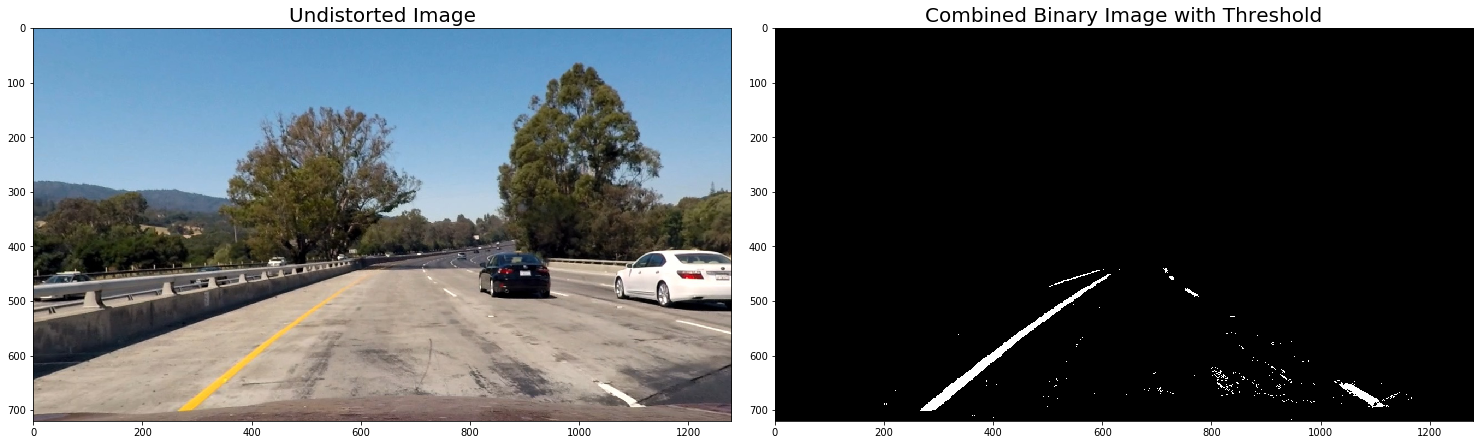

In [26]:
#display an output
image = mpimg.imread('test_images/test1.jpg')
camera_calibration = Calibration()
undistorted_image = camera_calibration.undistort(image)

#apply the binary threshold
binary_thresh = Binary_Threshold()
combined_image = binary_thresh.combined_binary_image(undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.tight_layout()

ax1.imshow(undistorted_image)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(combined_image, cmap = 'gray')
ax2.set_title('Combined Binary Image with Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/threshold_image')

### Part 3: Image Perspective Transform

In [5]:

class Perspective_Transform():
    '''Computes the perspective transform matrix M given the source and destination points'''
    def __init__(self):
        
        image_size = (720, 1280)
        
        #source points 
        self.src = np.float32(
            [[(image_size[1] / 2) - 60, image_size[0] / 2 + 100], 
            [((image_size[1] / 6) - 10), image_size[0]], 
            [(image_size[1] * 5 / 6) + 60, image_size[0]],
            [(image_size[1] / 2 + 60), image_size[0] / 2 + 100]])
        
        #destination points 
        self.dst = np.float32(
            [[(image_size[1] / 4), 0],
            [(image_size[1] / 4), image_size[0]],
            [(image_size[1] * 3 / 4), image_size[0]],
            [(image_size[1] * 3 / 4), 0]])
        
        #compute the transform M
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        
        #compute the inverse perspective transform
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def warp(self, image): 
        warped = cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR)
        return warped
    

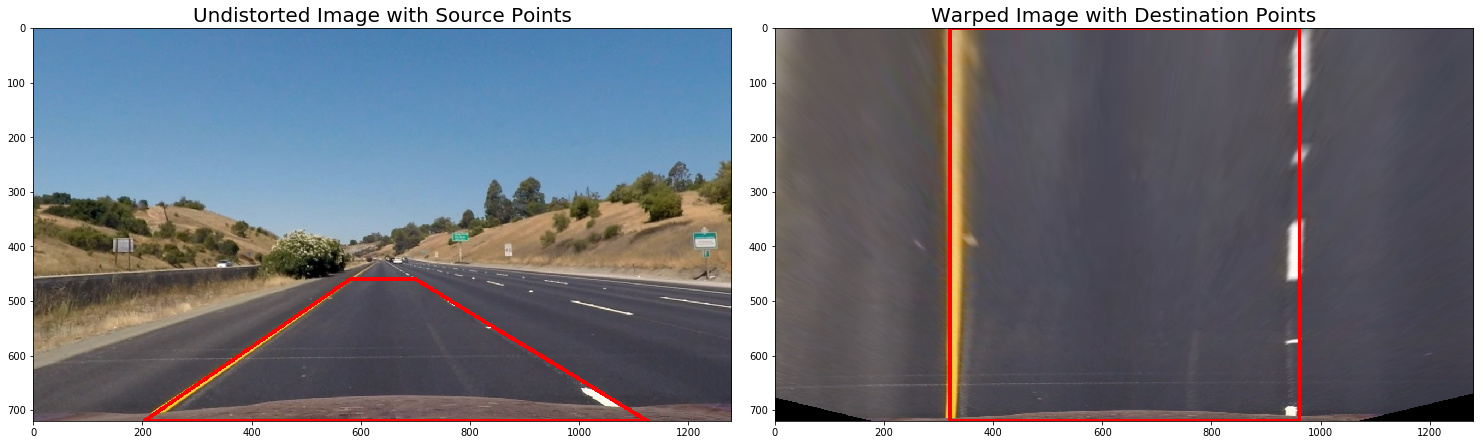

In [27]:
#display an output
image = mpimg.imread('test_images/straight_lines1.jpg')
camera_calibration = Calibration()
undistorted_image = camera_calibration.undistort(image)

#apply the perspective transform
perspective_transform = Perspective_Transform()
warped = perspective_transform.warp(undistorted_image)

#draw the source, destination points
cv2.polylines(undistorted_image, [perspective_transform.src.astype(int)], True, (255, 0, 0), 5)
cv2.polylines(warped, [perspective_transform.dst.astype(int)], True, (255, 0, 0), 5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.tight_layout()

ax1.imshow(undistorted_image)
ax1.set_title('Undistorted Image with Source Points', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image with Destination Points', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/warped_image')

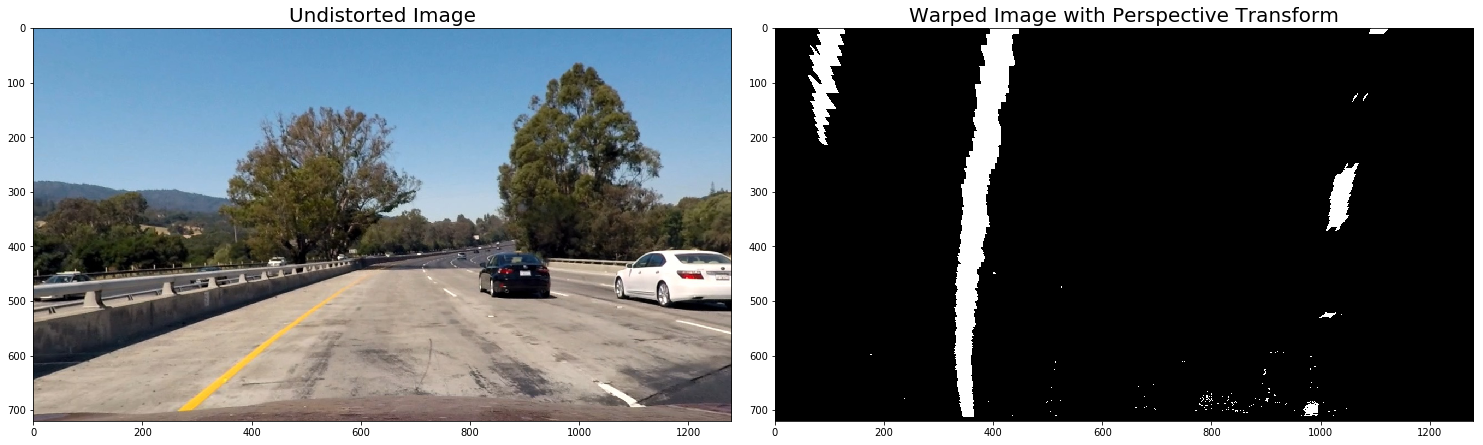

In [28]:
#display an output
image = mpimg.imread('test_images/test1.jpg')
camera_calibration = Calibration()
undistorted_image = camera_calibration.undistort(image)

#apply the binary threshold
binary_thresh = Binary_Threshold()
combined_image = binary_thresh.combined_binary_image(undistorted_image)

#apply the perspective transform
perspective_transform = Perspective_Transform()
warped = perspective_transform.warp(combined_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.tight_layout()

ax1.imshow(undistorted_image)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(warped, cmap = 'gray')
ax2.set_title('Warped Image with Perspective Transform', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/warped_perspective_transform_image')

### Part 4: Detect Lane Pixels, Find Lane Boundary, Determine Road Curvature, Perform Inverse Warp

In [8]:
#some functions that help the line class below

#set hyperparameters
#number is sliding windows
nwindows = 9

#width of the windows +/- margin
margin = 100

#set minimum number of pixels found to recenter window
minpix = 50

#define conversions for x and y from pixel space to meters
ym_per_pix = 30/720
xm_per_pix = 3.7/700

def get_fitx(warped, leftx, lefty, rightx, righty):
    
    #fits a second order polynomial to left and right fit
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    
    #calculate both polynomials with left_fit, right_fit, ploty
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    except TypeError:
        #avoids an error if left and right fit are none or incorrect
    
        print('The function failed to fit a line.')
        left_fit = 1 * ploty ** 2 + 1 * ploty
        right_fit = 1 * ploty ** 2 + 1 * ploty
    
    return left_fitx, right_fitx, ploty

def search_prior(warped, leftx, lefty, rightx, righty):
    '''Searches the area around the previous lane position to find the lane area in the next frame.'''

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #get activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #set the search area based on activated x values
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy
                            + left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2)
                            + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy
                            + right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2)
                            + right_fit[1] * nonzeroy + right_fit[2] + margin)))
    
    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

def fit_polynomial(warped):
    '''Fills a polynomial with the relevant pixels found using sliding windows.'''
    #used in fitting sliding windows
    #find the lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    #fit a second order polynomial to each 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #get x and y values for plotting purposes 
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    try: 
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        #avoids an error if left and right fit are none or incorrect
    
        print('The function failed to fit a line.')
        left_fit = 1 * ploty ** 2 + 1 * ploty
        right_fit = 1 * ploty ** 2 + 1 * ploty
    
    #visualization
    #colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    #plot the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color = 'yellow')
    #plt.plot(right_fitx, ploty, color = 'yellow')
    curve1 = np.column_stack((left_fitx, ploty))
    curve2 = np.column_stack((right_fitx, ploty))
    cv2.polylines(out_img, np.int_([curve1, curve2]), False, (0, 255, 0), 5)
    
    return out_img

def find_lane_pixels(warped):
    
    '''Creates sliding windows to find lane lines.'''
    #get a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis = 0)
    
    #create an output image to draw on and for visualizing the result 
    out_img = np.dstack((warped, warped, warped))
    
    #find the peak of the left and right halves of the histogram
    #these are the starting points for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #set the height of the window, based on nwindows and image shape
    window_height = np.int(warped.shape[0]//nwindows)
    
    #get x and y positions of nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #the current positions that will be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #empty lists to hold left and right pixel indices 
    left_lane_inds = []
    right_lane_inds = []
    
    #iterate through windows 
    for window in range(nwindows):
        
        #identify window boundaries in x and y and right, left
        win_y_low = warped.shape[0] - (window + 1) * window_height
        win_y_high = warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #draw windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        #identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low)
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low)
                          & (nonzerox < win_xright_high)).nonzero()[0]
        
        #append the indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #if found more than the minpix pixels recenter the next window on their mean position
        if len(good_left_inds) > minpix: 
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    #concatenate the arrays of indices
    try: 
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        #avoids an error if not implemented fully
        
        pass
    
    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [18]:
#set hyperparameters
#number is sliding windows
nwindows = 9

#width of the windows +/- margin
margin = 100

#set minimum number of pixels found to recenter window
minpix = 50

#define conversions for x and y from pixel space to meters
ym_per_pix = 30/720
xm_per_pix = 3.7/700

class Line():

    def __init__(self, frames = 1):

        self.left_fit = None
        self.right_fit = None
        
        self.frames = frames
        
        self.recent_xfit = []
        
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        
        
    def get_best_fitx(self, warped): 
        
        if self.frames == 1:
            
            #use sliding windows to find the lane line
            #get pixels
            self.leftx, self.lefty, self.rightx, self.righty, _ = find_lane_pixels(warped)
            
            #get polynomial x coordinates
            left_fitx, right_fitx, ploty = get_fitx(warped, self.leftx, self.lefty, self.rightx, self.righty)
            
            #append polynomial x
            self.recent_xfit.append((left_fitx, right_fitx))
            
            #get x coordinates for lane lines
            self.left_fit = left_fitx
            self.right_fit = right_fitx
            
        elif self.frames > 1:
            
            #use search_prior to find lane lines
            self.leftx, self.lefty, self.rightx, self.righty = search_prior(warped, self.leftx, self.lefty, self.rightx, self.righty)
            
            #get polynomial x coordinates 
            left_fitx, right_fitx, ploty = get_fitx(warped, self.leftx, self.lefty, self.rightx, self.righty)
            
            #append polynomial x
            self.recent_xfit.append((left_fitx, right_fitx))
            
            avg_xfit = np.average(self.recent_xfit, axis = 0)
            
            #get x coordinates for lane lines
            self.left_fit = avg_xfit[0]
            self.right_fit = avg_xfit[1]
            
    def plot_line(self, result):
        
        #generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
        
        #create an output image to draw on
        out_image = np.dstack((warped, warped, warped)) * 255
        
        #draw the lines
        left_curve = np.column_stack((self.left_fit, ploty))
        right_curve = np.column_stack((self.right_fit, ploty))
        
        cv2.polylines(out_image, np.int_([left_curve]), False, (255, 0, 0), 10)
        cv2.polylines(out_image, np.int_([right_curve]), False, (0, 0, 255), 10)
                
        return out_image
            
    def inverse(self, warped, undistort, Minv):
        '''Inverses the warping and draws measurements on the road.'''
        y = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
        
        #create an image to draw on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        #make the x and y points usable with cv2.fillPoly()
        left_points = np.array([np.transpose(np.vstack([self.left_fit, y]))])
        right_points = np.array([np.flipud(np.transpose(np.vstack([self.right_fit, y])))])
        points = np.hstack((left_points, right_points))
        cv2.fillPoly(color_warp, np.int_([points]), (0, 255, 0))
        
        #draw the lane lines
        left = np.column_stack((self.left_fit, y))
        right = np.column_stack((self.right_fit, y))
        
        cv2.polylines(color_warp, np.int_([left]), False, (255, 0, 0), 10)
        cv2.polylines(color_warp, np.int_([right]), False, (0, 0, 255), 10)
        
        #use Minv to put measurements on original image
        newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0]))
        #combine the result with the original image
        result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.5, 0)
        
        #find the position of the vehicle
        center_x_image = warped.shape[1] / 2
        center_x_lane = (self.left_fit[-1] + self.right_fit[-1]) / 2
        offset = (center_x_lane - center_x_image) * xm_per_pix
        
        #find the curvature
        left_curvature, right_curvature = self.get_curvature(warped)
        
        #print the curvature information on the image
        text = "{:.3f}km".format(left_curvature/1000.)
        cv2.putText(result, "Left curvature = " + text, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 3)

        text = "{:.3f}km".format(right_curvature/1000.)
        cv2.putText(result, "Right curvature = " + text, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 3)

        left_right = 'left' if offset < 0 else 'right'
        cv2.putText(result, "Vehicle is " + str(abs(round(offset, 3))) + "m " + left_right + " of center",(50, 190),
                   cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 3)

        #visualize image and lane center
        cv2.line(result, (int(center_x_lane), result.shape[0]), (int(center_x_lane), result.shape[0] - 20), 
                 (255, 255, 255), 6)
        cv2.line(result, (int(center_x_image), result.shape[0]), (int(center_x_image), result.shape[0] - 40), 
                 (255, 255, 255), 6)
        cv2.line(result, (int(center_x_lane), result.shape[0] - 2), (int(center_x_image), result.shape[0] - 2), 
                 (255, 255,255), 6)
                
        return result
    
    def get_curvature(self, warped): 
        '''Calculates the road curvature'''
        
        leftx = self.left_fit[::-1]
        rightx = self.right_fit[::-1]
        
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        
        #for polynomials to x, y in world space
        left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
        
        #define y value where we want radius of curvature
        y_eval = np.max(ploty)
        
        #calculation of R_curve (radius of curvature)
        left_curvature = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curvature = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        return(left_curvature, right_curvature)


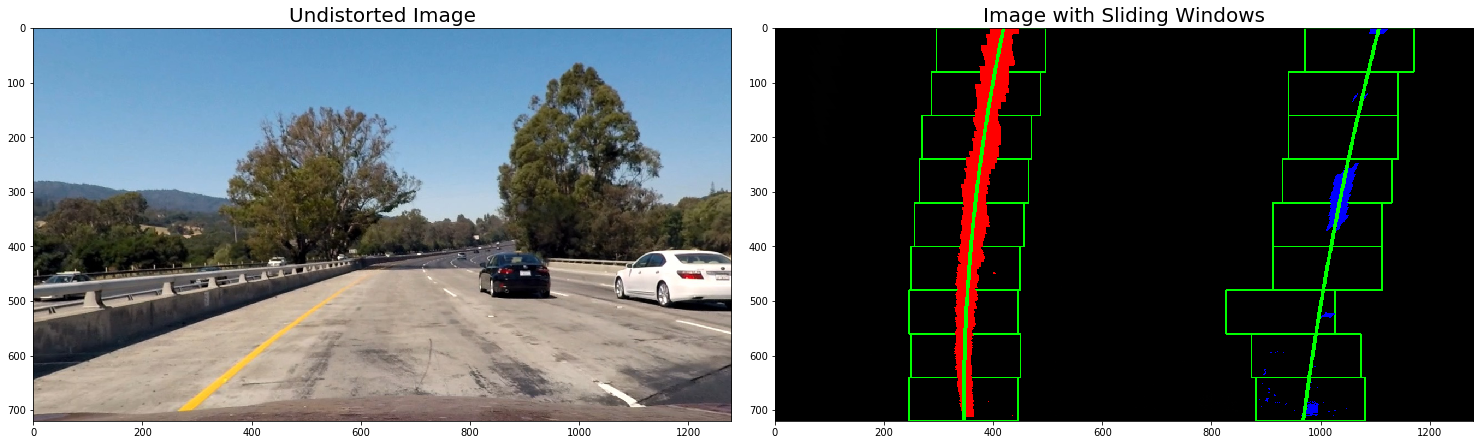

In [29]:
#display an output
image = mpimg.imread('test_images/test1.jpg')
camera_calibration = Calibration()
undistorted_image = camera_calibration.undistort(image)

#apply the binary threshold
binary_thresh = Binary_Threshold()
combined_image = binary_thresh.combined_binary_image(undistorted_image)

#apply the perspective transform
perspective_transform = Perspective_Transform()
warped = perspective_transform.warp(combined_image)

#sliding window 
sliding_window = fit_polynomial(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
f.tight_layout()

ax1.imshow(undistorted_image)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(sliding_window, cmap = 'gray')
ax2.set_title('Image with Sliding Windows', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/sliding_windows_image')

In [19]:
#process the test images

camera_calibration = Calibration()
binary_thresh = Binary_Threshold()
perspective_transform = Perspective_Transform()
line = Line()

def image_pipeline(image):
        
    #undistort the image
    undistorted_image = camera_calibration.undistort(image)
    
    #apply the binary threshold to the undistorted image
    combined_image = binary_thresh.combined_binary_image(undistorted_image)
    
    #apply the perspective transform
    warped = perspective_transform.warp(combined_image)
    
    #apply sliding windows
    sliding_window = fit_polynomial(warped)
    
    line.get_best_fitx(warped)
    
    output_image = line.inverse(warped, undistorted_image, perspective_transform.Minv)
    
    return undistorted_image, sliding_window, output_image
    

In [24]:
#process the video 

camera_calibration = Calibration()
binary_thresh = Binary_Threshold()
perspective_transform = Perspective_Transform()
line = Line(frames = 1)

def video_pipeline(image): 
    
    #undistort the image
    undistorted_image = camera_calibration.undistort(image)
    
    #apply the binary threshold to the undistorted image
    combined_image = binary_thresh.combined_binary_image(undistorted_image)
    
    #apply the perspective transform
    warped = perspective_transform.warp(combined_image)
    
    line.get_best_fitx(warped)
    line_img = line.plot_line(warped)
    road_img = line.inverse(warped, undistorted_image, perspective_transform.Minv)
    
    #output_image = line.inverse(warped, undistorted_image, perspective_transform.Minv)

    line.frames += 1
    
    return road_img

### Part 5: Visual Display of Lane Boundaries, Curvature, and Vehicle Position

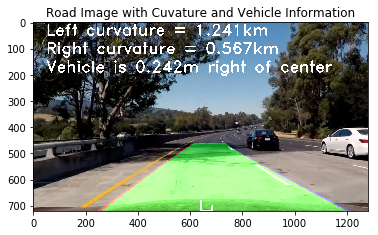

In [30]:
#test the pipeline on the test images
for test_image in os.listdir('test_images/'):
    image = mpimg.imread('test_images/' + test_image)
    undistorted_image, sliding_window, output_image = image_pipeline(image)
    plt.title('Road Image with Cuvature and Vehicle Information')
    plt.imshow(output_image)
    plt.savefig('output_images/road_and_info_image')

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
output = 'project_video_output.mp4'

clip1 = VideoFileClip('project_video.mp4')
out_clip = clip1.fl_image(video_pipeline)

%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:14<00:00,  5.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 14s
